In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.regularizers import l2
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Carregar conjunto de dados

In [2]:
## Carregando os dados
df = pd.read_csv("data/train.csv")

# 2. Extração e tratamento de características

## 2.1 Criação de variável 'strata' para estratificação dos dados

In [3]:
##Criando variável para fazer divisão ideal dos dados
df['strata'] = df['Pclass'].astype(str) + "_" + \
               df['Survived'].astype(str)

## 2.2 Extração de características 

In [4]:
##Engenharia de features
#Ajuste no nome por título
df["Name"] = df["Name"].str.extract(r',\s*([^\.]+)\.')

##Se possui cabine múltipla
df['Cabin_Multiple'] = df['Cabin'].apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
df['Cabin_Multiple'] = df['Cabin_Multiple'].apply(lambda x: 0 if x == 0 else 1)

##Prefixo da Cabine
df['Cabin_Pref'] = df['Cabin'].apply(lambda x: str(x)[0])

##Se o Ticket é numérico
df['Numeric_Ticket'] = df["Ticket"].apply(lambda x: 1 if x.isnumeric() else 0)

##Prefixo do Ticket
df["Prefix_Ticket"] = df["Ticket"].str.extract(r"^(.*?)(?=\s\d)")
df["Prefix_Ticket"] = df["Prefix_Ticket"].str.strip()
df["Prefix_Ticket"] = df["Prefix_Ticket"].fillna("n")

## 2.3 Tratamento de características

In [5]:
##Tratamento de dados
##Binarizando coluna 'Name'
df = pd.get_dummies(df, columns=['Name'], prefix='Name', dtype=int)

##Binarizar 'Sex'
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

##Binarizando 'Embarked'
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df = pd.get_dummies(df, columns=['Embarked'], prefix='Embarked', dtype=int)

##Binarizando 'Cabin_Pref'
df = pd.get_dummies(df, columns=['Cabin_Pref'], prefix='Cabin_Pref', dtype=int)

##Binarizando 'Prefix_Ticket'
df = pd.get_dummies(df, columns=['Prefix_Ticket'], prefix='Prefix_Ticket', dtype=int)

In [6]:
##Tratamento de Nulos da idade
com_idade = df[df['Age'].notnull()]
sem_idade = df[df['Age'].isnull()]

#Baseear a escolha da idade por
colunas_preditoras = ['Parch', 'Pclass', 'Sex', 'Cabin_Multiple', 'Fare', 'Name_Master',
 'Name_Miss',
 'Name_Mr',
 'Name_Mrs']

#Treino
modelo = RandomForestRegressor()
modelo.fit(com_idade[colunas_preditoras], com_idade['Age'])

#Predict
idades_previstas = modelo.predict(sem_idade[colunas_preditoras])

#Preenchuer
df.loc[df['Age'].isnull(), 'Age'] = idades_previstas

In [7]:
##'Cabin'
df = df.drop(columns = {'Cabin'})

In [8]:
columns = ['strata', 'Pclass',
 'Age',
 'Parch', 
 'SibSp', 
 'Fare',
 'Survived',
 'Cabin_Multiple',
 'Sex',
 'Name_Miss',
 'Name_Mr',
 'Name_Mrs',
 'Embarked_C',
 'Embarked_S',
 'Embarked_Q']

df = df[columns]
df

,strata,Pclass,Age,Parch,SibSp,Fare,Survived,Cabin_Multiple,Sex,Name_Miss,Name_Mr,Name_Mrs,Embarked_C,Embarked_S,Embarked_Q
0,3_0,3,22.0000,0,1,7.2500,0,0,1,0,1,0,0,1,0
1,1_1,1,38.0000,0,1,71.2833,1,1,0,0,0,1,1,0,0
2,3_1,3,26.0000,0,0,7.9250,1,0,0,1,0,0,0,1,0
3,1_1,1,35.0000,0,1,53.1000,1,1,0,0,0,1,0,1,0
4,3_0,3,35.0000,0,0,8.0500,0,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2_0,2,27.0000,0,0,13.0000,0,0,1,0,0,0,0,1,0
887,1_1,1,19.0000,0,0,30.0000,1,1,0,1,0,0,0,1,0
888,3_0,3,7.4045,2,1,23.4500,0,0,0,1,0,0,0,1,0
889,1_1,1,26.0000,0,0,30.0000,1,1,1,0,1,0,1,0,0


In [9]:
df['Cabin_Multiple'].value_counts()

Cabin_Multiple
0    687
1    204
Name: count, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   strata          891 non-null    object 
 1   Pclass          891 non-null    int64  
 2   Age             891 non-null    float64
 3   Parch           891 non-null    int64  
 4   SibSp           891 non-null    int64  
 5   Fare            891 non-null    float64
 6   Survived        891 non-null    int64  
 7   Cabin_Multiple  891 non-null    int64  
 8   Sex             891 non-null    int64  
 9   Name_Miss       891 non-null    int64  
 10  Name_Mr         891 non-null    int64  
 11  Name_Mrs        891 non-null    int64  
 12  Embarked_C      891 non-null    int64  
 13  Embarked_S      891 non-null    int64  
 14  Embarked_Q      891 non-null    int64  
dtypes: float64(2), int64(12), object(1)
memory usage: 104.5+ KB


# 3. Divisão do conjunto de dados

In [11]:
# Separar X e y
X = df.drop(columns=['Survived', 'strata'])
y = df['Survived']
strata = df['strata']

In [12]:
# 2. Coluna sensível (única)
sensitive_col = 'Name_Mr'

# 3. Separar colunas para normalizar (excluindo a coluna sensível)
cols_to_normalize = [col for col in X.columns if col != sensitive_col]

In [13]:
# 4. Normalizar antes da divisão (sem incluir coluna sensível)
scaler = MinMaxScaler()
X_scaled = X.copy()
X_scaled[cols_to_normalize] = scaler.fit_transform(X_scaled[cols_to_normalize])

In [14]:
# 5. Dividir os dados normalizados
X_train, X_temp, y_train, y_temp, strata_train, strata_temp = train_test_split(
    X_scaled, y, strata,
    test_size=0.3,
    stratify=strata,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=strata_temp,
    random_state=42
)

In [15]:
X.columns

Index(['Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
       'Name_Miss', 'Name_Mr', 'Name_Mrs', 'Embarked_C', 'Embarked_S',
       'Embarked_Q'],
      dtype='object')

In [16]:
df_test_raw = X_test
df_raw_train = X_train

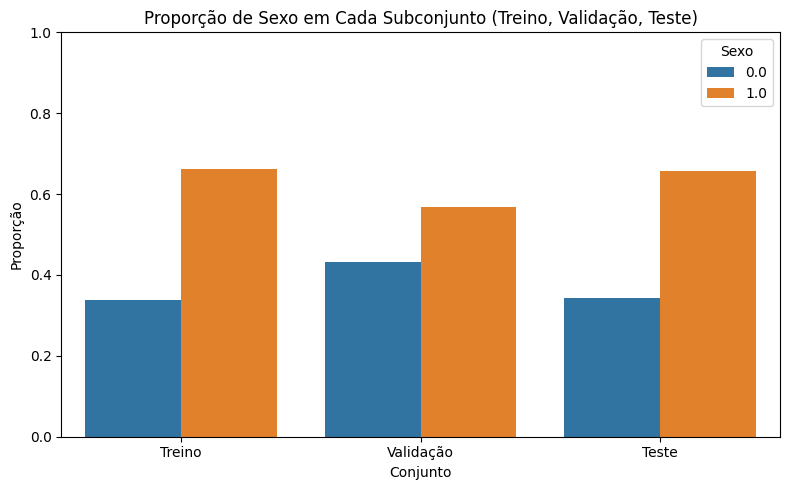

In [17]:
# Criar um DataFrame auxiliar com os conjuntos e seus respectivos sexos
def create_summary(df, name, coluna):
    return df[coluna].value_counts(normalize=True).rename_axis(coluna).reset_index(name='Proportion').assign(Subset=name)

summary_train = create_summary(X_train, 'Treino', 'Sex')
summary_val = create_summary(X_val, 'Validação', 'Sex')
summary_test = create_summary(X_test, 'Teste', 'Sex')

# Combinar os dados em um único DataFrame
summary_df = pd.concat([summary_train, summary_val, summary_test])

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Subset', y='Proportion', hue='Sex')
plt.title('Proporção de Sexo em Cada Subconjunto (Treino, Validação, Teste)')
plt.ylim(0, 1)
plt.ylabel('Proporção')
plt.xlabel('Conjunto')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

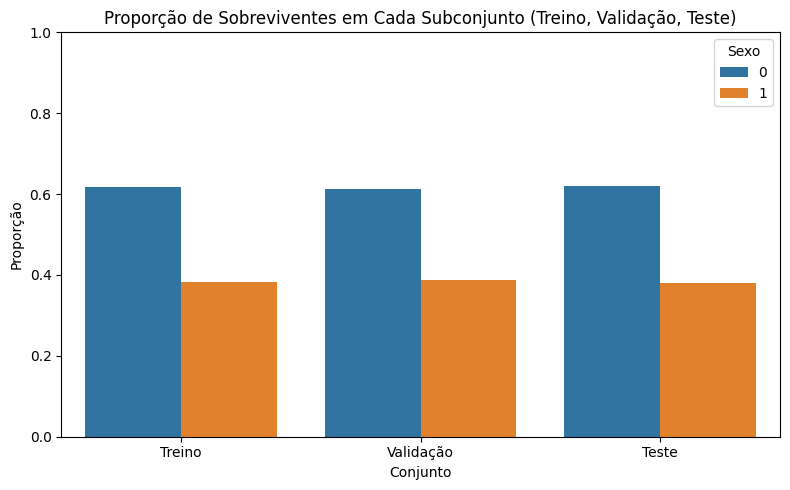

In [18]:
# Transformar as Series y_* em DataFrames com coluna nomeada
y_train_df = y_train.to_frame(name='Survived')
y_val_df = y_val.to_frame(name='Survived')
y_test_df = y_test.to_frame(name='Survived')

# Agora sim, aplicar a função corretamente
summary_train = create_summary(y_train_df, 'Treino', 'Survived')
summary_val = create_summary(y_val_df, 'Validação', 'Survived')
summary_test = create_summary(y_test_df, 'Teste', 'Survived')

# Combinar os dados em um único DataFrame
summary_df = pd.concat([summary_train, summary_val, summary_test])

# Plotar
plt.figure(figsize=(8, 5))
sns.barplot(data=summary_df, x='Subset', y='Proportion', hue='Survived')
plt.title('Proporção de Sobreviventes em Cada Subconjunto (Treino, Validação, Teste)')
plt.ylim(0, 1)
plt.ylabel('Proporção')
plt.xlabel('Conjunto')
plt.legend(title='Sexo')
plt.tight_layout()
plt.show()

# 4. Normalização

In [19]:
# 6. Função para gerar sample weights com base em UMA coluna sensível
def compute_sample_weights_single(df, col):
    group_counts = df[col].value_counts()
    total = len(df)
    weights = total / (len(group_counts) * group_counts)
    sample_weights = df[col].map(weights).values
    return sample_weights

In [20]:
sample_weights_train = compute_sample_weights_single(X_train, sensitive_col)

In [21]:
#scaler = MinMaxScaler()
## scaler = RobustScaler()
## scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
#X_test = scaler.transform(X_test)

# 5. Treinamento

In [22]:
# 8. Remover coluna sensível dos dados de entrada
X_train_input = X_train.drop(columns=[sensitive_col]).values
X_val_input = X_val.drop(columns=[sensitive_col]).values
X_test_input = X_test.drop(columns=[sensitive_col]).values

In [23]:
##Modelo MLP
model = Sequential([
    Dense(32, input_dim=X_train_input.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

history = model.fit(
    X_train_input, y_train,
    sample_weight=sample_weights_train,
    validation_data=(X_val_input, y_val),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6219 - loss: 1.1485 - val_accuracy: 0.7015 - val_loss: 1.0573
Epoch 2/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6949 - loss: 1.0526 - val_accuracy: 0.7537 - val_loss: 0.9728
Epoch 3/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7147 - loss: 0.9763 - val_accuracy: 0.7985 - val_loss: 0.8979
Epoch 4/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7448 - loss: 0.9158 - val_accuracy: 0.8134 - val_loss: 0.8316
Epoch 5/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7822 - loss: 0.8606 - val_accuracy: 0.8358 - val_loss: 0.7756
Epoch 6/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7946 - loss: 0.8076 - val_accuracy: 0.8209 - val_loss: 0.7338
Epoch 7/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7945 - loss: 0.7453 - val_accuracy: 0.8134 - val_loss: 0.7002
Epoch 8/300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7789 - loss: 0.7202 - val_accuracy: 0.7910 - 

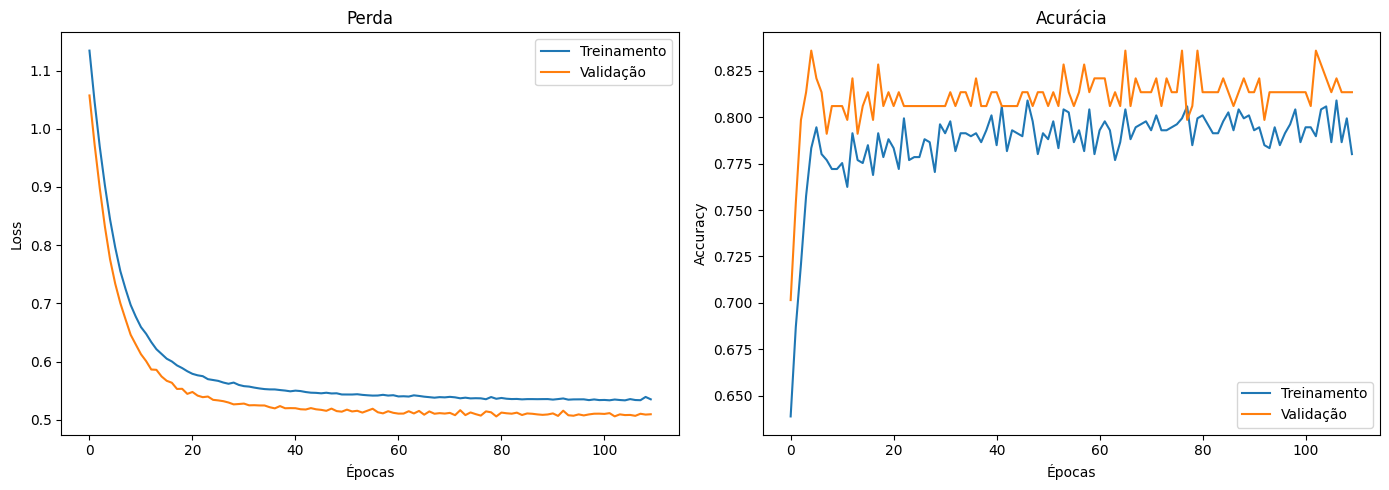

In [25]:
##Plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Treinamento')
plt.plot(history.history['val_loss'], label='Validação')
plt.title("Perda")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Treinamento')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title("Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89        83
           1       0.86      0.75      0.80        51

    accuracy                           0.86       134
   macro avg       0.86      0.84      0.85       134
weighted avg       0.86      0.86      0.86       134

Matriz de Confusão:
[[77  6]
 [13 38]]


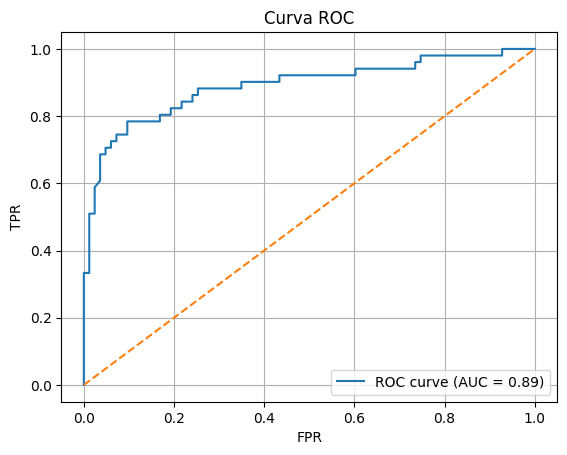

In [26]:
##Avaliação
y_pred_probs = model.predict(X_test_input).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 6. Análise de erro

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\3118115229.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_class = df_result.groupby('Pclass').apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\3118115229.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_class, x='Pclass', y='accuracy', palette='viridis')


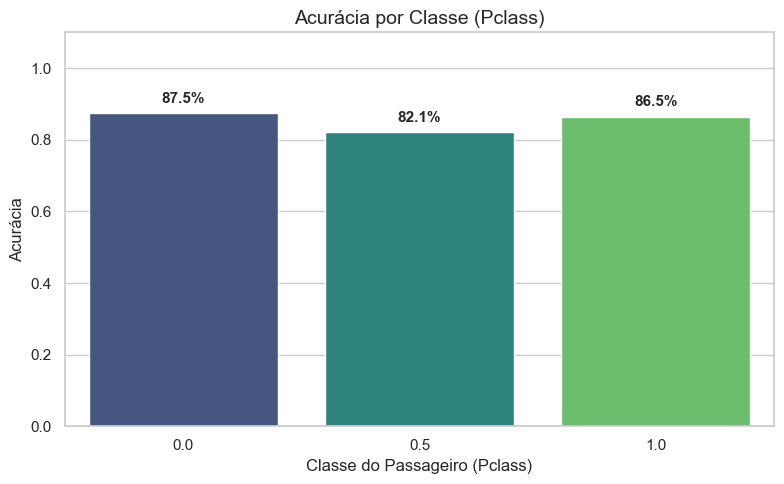

In [27]:
#@Juntar com a coluna Pclass (que vem da versão original dos dados)
df_result = pd.DataFrame({
    'Pclass': df_test_raw['Pclass'].values,
    'y_true': y_test,
    'y_pred': y_pred
})
##Calcular acurácia por Pclass
acc_by_class = df_result.groupby('Pclass').apply(
    lambda g: accuracy_score(g['y_true'], g['y_pred'])
).reset_index(name='accuracy')

##Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=acc_by_class, x='Pclass', y='accuracy', palette='viridis')

#Adicionar porcentagens no topo das barras
for i, row in acc_by_class.iterrows():
    acc_percent = f"{row['accuracy']*100:.1f}%"
    ax.text(i, row['accuracy'] + 0.02, acc_percent, ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.title('Acurácia por Classe (Pclass)', fontsize=14)
plt.xlabel('Classe do Passageiro (Pclass)', fontsize=12)
plt.ylabel('Acurácia', fontsize=12)
plt.ylim(0, 1.1)  # Deixar espaço para o texto acima das barras
plt.tight_layout()
plt.show()

In [28]:
def check_accuracy(coluna):
    df_result = pd.DataFrame({
        coluna: df_test_raw[coluna].values,
        'y_true': y_test,
        'y_pred': y_pred
    })
    
    ##Calcular acurácia por sexo
    acc_by_sex = df_result.groupby(coluna).apply(
        lambda g: accuracy_score(g['y_true'], g['y_pred'])
    ).reset_index(name='accuracy')
    
    ##Plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')
    
    #Adicionar porcentagens no topo das barras
    for i, row in acc_by_sex.iterrows():
        acc_percent = f"{row['accuracy']*100:.1f}%"
        ax.text(i, row['accuracy'] + 0.02, acc_percent, ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.title(f'Acurácia por {coluna}', fontsize=14)
    plt.xlabel(coluna, fontsize=12)
    plt.ylabel('Acurácia', fontsize=12)
    plt.ylim(0, 1.1)
    plt.tight_layout()
    plt.show()

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


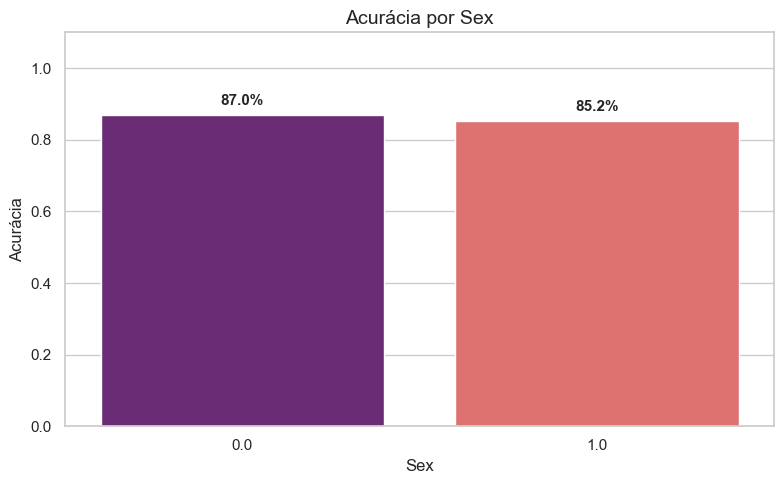

In [29]:
check_accuracy('Sex')

In [30]:
columns

['strata',
 'Pclass',
 'Age',
 'Parch',
 'SibSp',
 'Fare',
 'Survived',
 'Cabin_Multiple',
 'Sex',
 'Name_Miss',
 'Name_Mr',
 'Name_Mrs',
 'Embarked_C',
 'Embarked_S',
 'Embarked_Q']

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


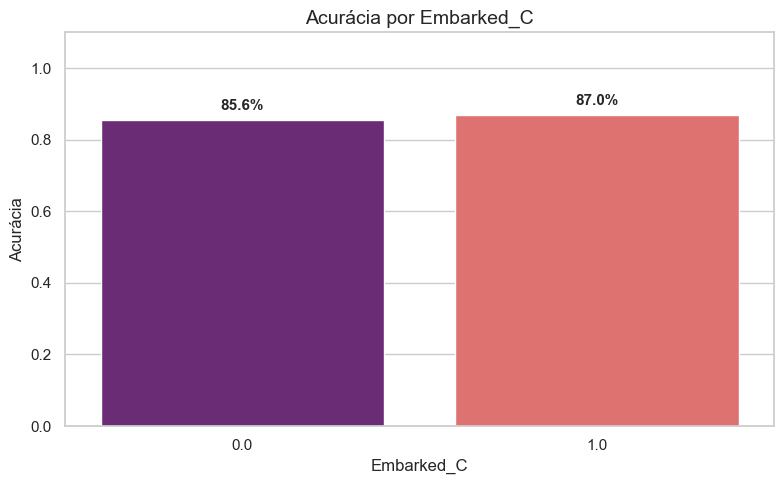

In [31]:
check_accuracy('Embarked_C')

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


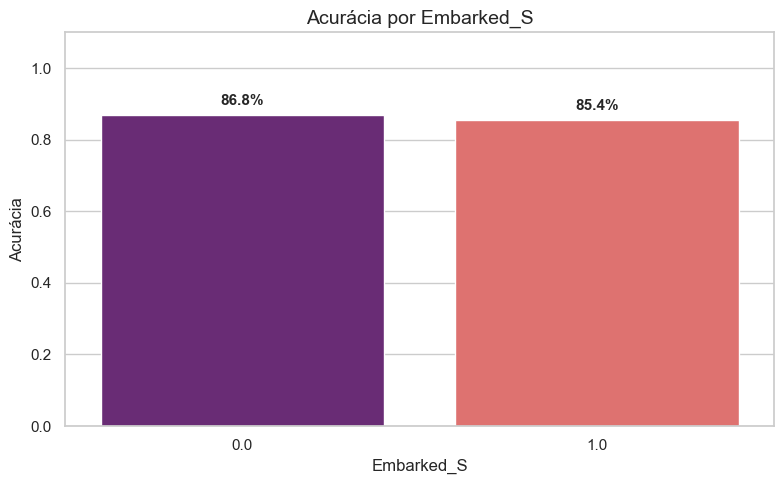

In [32]:
check_accuracy('Embarked_S')

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


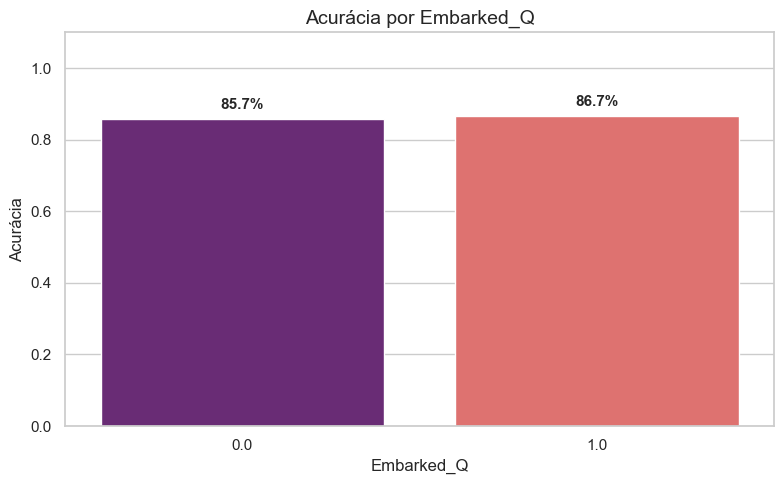

In [33]:
check_accuracy('Embarked_Q')

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


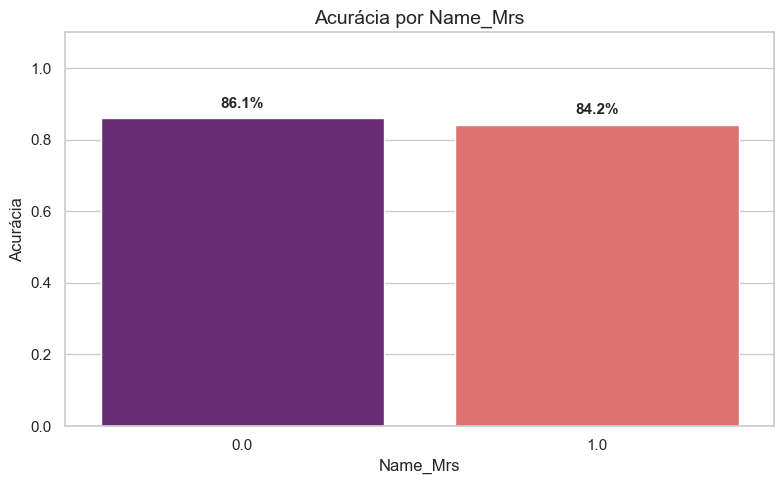

In [34]:
check_accuracy('Name_Mrs')

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


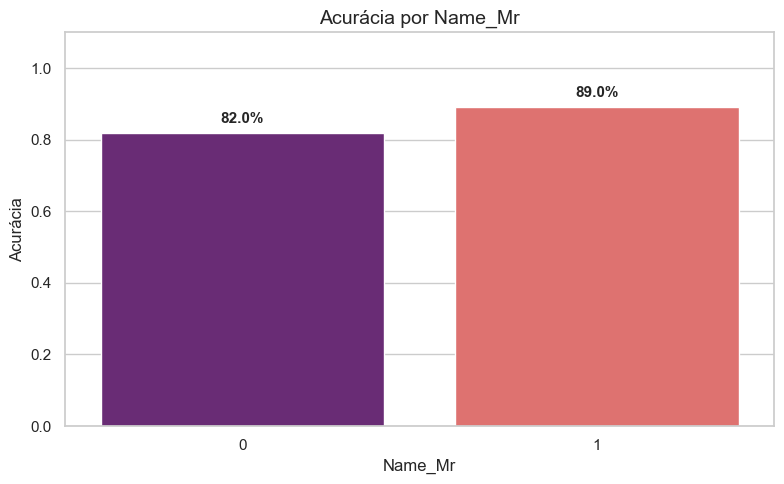

In [35]:
check_accuracy('Name_Mr')

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


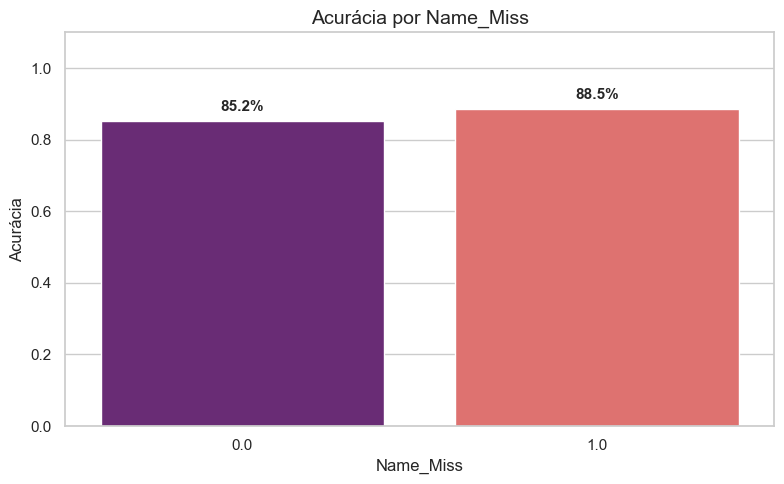

In [36]:
check_accuracy('Name_Miss')

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


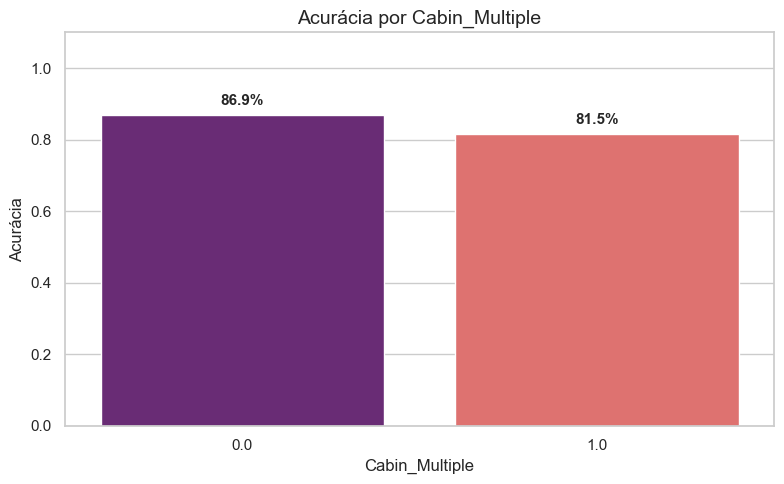

In [37]:
check_accuracy('Cabin_Multiple')

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


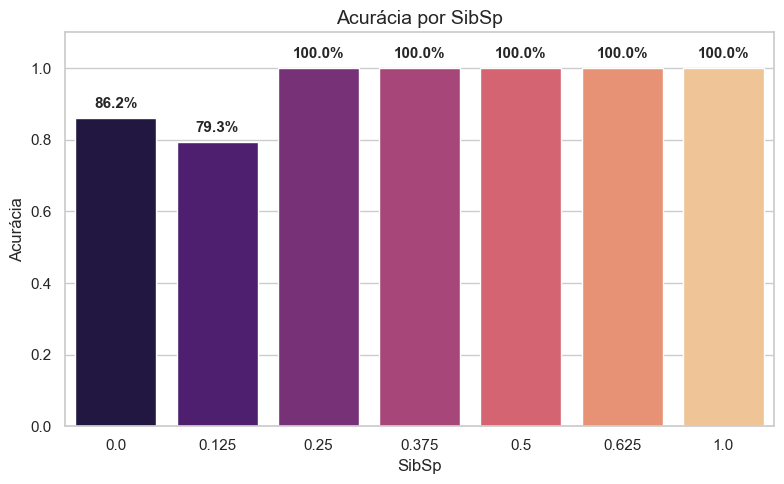

In [38]:
check_accuracy('SibSp')

C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_by_sex = df_result.groupby(coluna).apply(
C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\1748256875.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=acc_by_sex, x=coluna, y='accuracy', palette='magma')


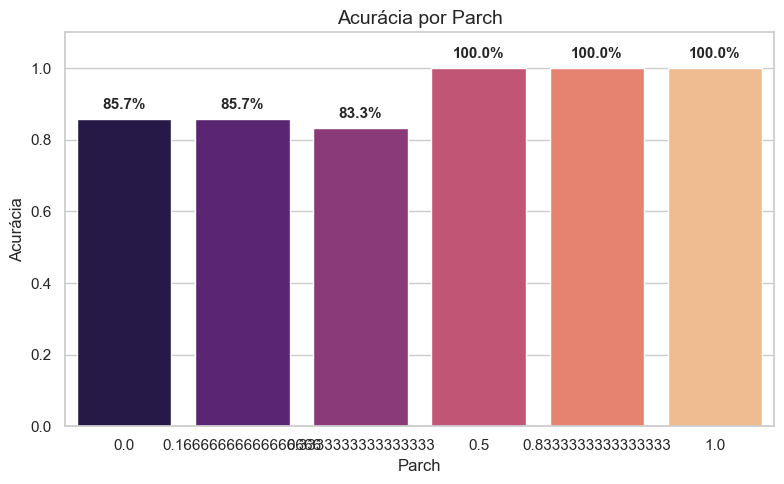

In [39]:
check_accuracy('Parch')

In [40]:
df_raw_train['Pclass'].value_counts()

Pclass
1.0    343
0.0    151
0.5    129
Name: count, dtype: int64

In [41]:
pd.crosstab(df_raw_train['Cabin_Multiple'], y_train, normalize='index')


Survived,0,1
Cabin_Multiple,,
0.0,0.699580,0.300420
1.0,0.346939,0.653061


# Avaliação em dados de teste fictícios

In [42]:
## Carregando os dados
df_test = pd.read_csv("data/test_fake.csv")

Index(['Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
       'Name_Master', 'Name_Miss', 'Name_Mr', 'Name_Mrs', 'Embarked_C',
       'Embarked_S', 'Embarked_Q', 'Cabin_Pref_B', 'Cabin_Pref_C',
       'Cabin_Pref_D', 'Cabin_Pref_E', 'Cabin_Pref_n', 'Prefix_Ticket_PC'],
      dtype='object')

In [43]:
df_test.drop(columns=['PassengerId'], inplace=True)

In [44]:
df_test

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,"Smith, Mrs. Anna",female,30,1,0,PC 17599,120.00,B28,C,1
1,3,"Doe, Miss. Mary",female,25,0,0,A/5 21171,7.25,NaN,S,1
2,1,"Brown, Master. Henry",male,6,2,2,113781,150.00,C83,C,1
3,3,"Lee, Miss. Sophie",female,8,1,3,W./C. 6608,21.00,NaN,S,1
4,1,"Johnson, Mr. Robert",male,40,0,0,PC 17756,108.90,C85,S,0
5,3,"Williams, Mr. John",male,35,0,0,373450,8.05,NaN,S,0
6,1,"Taylor, Mrs. Grace",female,68,0,1,PC 17483,120.00,E31,C,1
7,3,"Clark, Mrs. Ellen",female,70,0,0,330877,7.75,NaN,Q,0
8,1,"Anderson, Mr. George",male,72,0,1,113798,80.00,D33,S,0
9,3,"Martins, Mr. Pedro",male,74,0,0,345763,6.95,NaN,S,0


In [45]:
# Cabin_Multiple: se houver mais de uma cabine listada
df_test['Cabin_Multiple'] = df_test['Cabin'].apply(lambda x: 1 if pd.notna(x) and ' ' in str(x) else 0)

# Título (prefixo do nome)
df_test['Title'] = df_test['Name'].str.extract(r',\s*([^\.]*)\.', expand=False)

# One-hot titles
df_test['Name_Miss'] = (df_test['Title'] == 'Miss').astype(int)
df_test['Name_Mr'] = (df_test['Title'] == 'Mr').astype(int)
df_test['Name_Mrs'] = (df_test['Title'] == 'Mrs').astype(int)

# One-hot encoding de Embarked
embarked_dummies = pd.get_dummies(df_test['Embarked'], prefix='Embarked')
for col in ['Embarked_C', 'Embarked_S', 'Embarked_Q']:
    df_test[col] = embarked_dummies.get(col, pd.Series(0, index=df_test.index))

# Cabin prefix (primeira letra da cabine)
df_test['Cabin_Pref'] = df_test['Cabin'].astype(str).str[0]
cabin_dummies = pd.get_dummies(df_test['Cabin_Pref'], prefix='Cabin_Pref')
for col in ['B', 'C', 'D', 'E', 'n']:
    df_test[f'Cabin_Pref_{col}'] = cabin_dummies.get(f'Cabin_Pref_{col}', pd.Series(0, index=df_test.index))

# Prefix_Ticket_PC
df_test['Prefix_Ticket_PC'] = df_test['Ticket'].astype(str).str.startswith('PC').astype(int)

# Converter sexo para numérico
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

# Converte todas as colunas booleanas para int
bool_cols = df_test.select_dtypes(include='bool').columns
df_test[bool_cols] = df_test[bool_cols].astype(int)

# Define colunas finais de entrada (mantém Survived separada)
final_features = [
    'Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex',
    'Name_Mr', 'Name_Miss', 'Name_Mrs',
    'Embarked_C', 'Embarked_S', 'Embarked_Q',
]

# Garante que apenas essas colunas + Survived permaneçam
cols_to_keep = final_features + ['Survived']
df_test = df_test[cols_to_keep].copy()


In [46]:
df_test

,Pclass,Age,Parch,SibSp,Fare,Cabin_Multiple,Sex,Name_Mr,Name_Miss,Name_Mrs,Embarked_C,Embarked_S,Embarked_Q,Survived
0,1,30,0,1,120.00,0,1,0,0,1,1,0,0,1
1,3,25,0,0,7.25,0,1,0,1,0,0,1,0,1
2,1,6,2,2,150.00,0,0,0,0,0,1,0,0,1
3,3,8,3,1,21.00,0,1,0,1,0,0,1,0,1
4,1,40,0,0,108.90,0,0,1,0,0,0,1,0,0
5,3,35,0,0,8.05,0,0,1,0,0,0,1,0,0
6,1,68,1,0,120.00,0,1,0,0,1,1,0,0,1
7,3,70,0,0,7.75,0,1,0,0,1,0,0,1,0
8,1,72,1,0,80.00,0,0,1,0,0,0,1,0,0
9,3,74,0,0,6.95,0,0,1,0,0,0,1,0,0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.50      0.40      0.44         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.49        10
weighted avg       0.50      0.50      0.49        10

Matriz de Confusão:
[[3 2]
 [3 2]]


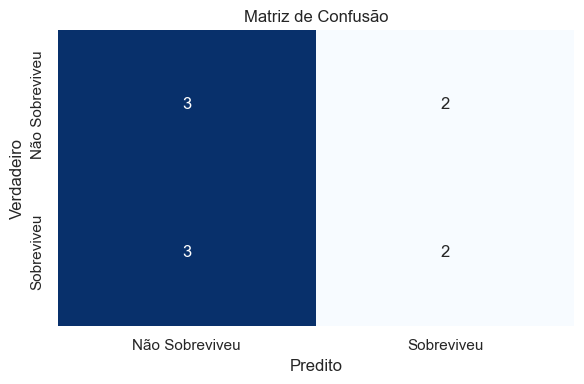

In [50]:
# Corrigir: precisa aplicar o mesmo scaler usado no treino
X_test = df_test.drop(columns=['Survived', 'Name_Mr'])
X_test_scaled = scaler.transform(X_test)  # <- normalização aqui!

y_test = df_test['Survived']

# Previsão dos dados de teste
y_pred_probs = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Relatório
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# Plotando a matriz de confusão como imagem .png
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Não Sobreviveu', 'Sobreviveu'],
            yticklabels=['Não Sobreviveu', 'Sobreviveu'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.savefig('matriz_confusao.png')  # Salva como imagem .png
plt.show()


# Avaliação do Conjunto de Teste sem GroundTruth

In [51]:
# Carregar o arquivo
df_kaggle_test = pd.read_csv("data/test.csv")

# Cabin_Multiple
df_kaggle_test['Cabin_Multiple'] = df_kaggle_test['Cabin'].apply(lambda x: 1 if pd.notna(x) and ' ' in str(x) else 0)

# Extrair título
df_kaggle_test['Title'] = df_kaggle_test['Name'].str.extract(r',\s*([^\.]*)\.', expand=False)
df_kaggle_test['Name_Miss'] = (df_kaggle_test['Title'] == 'Miss').astype(int)
df_kaggle_test['Name_Mr'] = (df_kaggle_test['Title'] == 'Mr').astype(int)
df_kaggle_test['Name_Mrs'] = (df_kaggle_test['Title'] == 'Mrs').astype(int)

# One-hot Embarked
embarked_dummies = pd.get_dummies(df_kaggle_test['Embarked'], prefix='Embarked')
for col in ['Embarked_C', 'Embarked_S', 'Embarked_Q']:
    df_kaggle_test[col] = embarked_dummies.get(col, pd.Series(0, index=df_kaggle_test.index))



# Converter 'Sex' para numérico
df_kaggle_test['Sex'] = df_kaggle_test['Sex'].map({'male': 0, 'female': 1})

# Corrigir valores booleanos
bool_cols = df_kaggle_test.select_dtypes(include='bool').columns
df_kaggle_test[bool_cols] = df_kaggle_test[bool_cols].astype(int)

# Tratar valores ausentes (Age, Fare podem estar ausentes)
df_kaggle_test['Age'] = df_kaggle_test['Age'].fillna(df_kaggle_test['Age'].median())
df_kaggle_test['Fare'] = df_kaggle_test['Fare'].fillna(df_kaggle_test['Fare'].median())

# Selecionar apenas as colunas de features
final_features = [
    'Pclass', 'Age', 'Parch', 'SibSp', 'Fare', 'Cabin_Multiple', 'Sex', 'Name_Miss', 'Name_Mr', 'Name_Mrs',
    'Embarked_C', 'Embarked_S', 'Embarked_Q',
]

X_kaggle_test = df_kaggle_test[final_features]

In [52]:
# Previsões
y_pred_probs = model.predict(X_kaggle_test).ravel()
y_pred = (y_pred_probs > 0.5).astype(int)

# Criar CSV com os resultados
submission = pd.DataFrame({
    'PassengerId': df_kaggle_test['PassengerId'],
    'Survived': y_pred
})

# Salvar
submission.to_csv('data/submission.csv', index=False)

InvalidArgumentError: Graph execution error:

Detected at node sequential_1/dense_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\asyncio\base_events.py", line 645, in run_forever

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\asyncio\base_events.py", line 1999, in _run_once

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\asyncio\events.py", line 88, in _run

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\IPython\core\interactiveshell.py", line 3100, in run_cell

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\IPython\core\interactiveshell.py", line 3155, in _run_cell

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\IPython\core\interactiveshell.py", line 3367, in run_cell_async

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\IPython\core\interactiveshell.py", line 3612, in run_ast_nodes

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\IPython\core\interactiveshell.py", line 3672, in run_code

  File "C:\Users\T18228\AppData\Local\Temp\ipykernel_32208\3684206297.py", line 5, in <module>

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 566, in predict

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 260, in one_step_on_data_distributed

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 250, in one_step_on_data

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 105, in predict_step

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\models\sequential.py", line 220, in call

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\models\functional.py", line 183, in call

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\ops\function.py", line 177, in _run_through_graph

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\models\functional.py", line 648, in call

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\layers\core\dense.py", line 155, in call

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\activations\activations.py", line 47, in relu

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\activations\activations.py", line 101, in static_call

  File "C:\Users\T18228\AppData\Local\anaconda3\envs\main\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [32,13], In[1]: [12,32]
	 [[{{node sequential_1/dense_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_20654]